In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import logging
import importlib

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from itertools import product

%matplotlib inline

In [2]:
# import theory stuff

%reload_ext autoreload
%autoreload 2

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

from utilities.corporate_design_colors_v4 import cmap, colors
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

from theory.models.functions import bin_y_over_x

from theory.models.constants import G_0_S, G_0_muS
importlib.reload(sys.modules["theory.models.constants"])

loaded constants...
loaded constants...


<module 'theory.models.constants' from '/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/constants.py'>

In [3]:
# PAT parameter
# nu_GHz: float = 7.8  # n = many, gap closing
# nu_GHz: float = 8.0 # n = inf, ever so slight gap closing
nu_GHz, V_off = 13.6, -17e-3  # n = perfect, slight gap closing
# nu_GHz: float = 15.0 # n = 2, crap
# nu_GHz, V_off = 18.3, -13e-3  # n = okay, slight gap closing
# nu_GHz: float = 19.3 # n = 3, crap

# Initial guessing parameter
tau_0_arbu: float = 0.18861238619219342
T_0_K: float = 0.3
Delta_0_meV: float = 0.1954362246372233
Gamma_0_meV: float = 0.0073389200475204005

# Data
V_mV: NDArray[np.float64] = np.linspace(-1.2, 1.2, 1201, dtype="float64")
V_raw_mV: NDArray[np.float64] = np.linspace(-1.3, 1.3, 10401, dtype="float64")

# exp_data evaluation
sampling_rate: float = 37.3  # Hz
window: tuple[int, int] = (0, 0)
skip: tuple[int | None, int | None] = (20, None)

# interesting Amplitudes
A_lim: tuple[float, float] = (0, 605)  # mV
A_interest: list[int] = [0, 10, 50, 100, 250, 375, 500]  # mV

# simulation parameter
N: int = 100

In [4]:
# vordefinitionen


# region shrink and expand blocks
def shrink_blocks(arr, x=0, y=0):
    """
    For each block of consecutive True values in a boolean array,
    set the first x and last y entries to False.
    """
    arr = arr.copy()
    N = len(arr)

    i = 0
    while i < N:
        if arr[i]:
            # block start
            start = i
            while i < N and arr[i]:
                i += 1
            end = i - 1  # block end (inclusive)

            # shrink block
            arr[start : start + x] = False
            arr[max(end - y + 1, start) : end + 1] = False
        else:
            i += 1
    return arr


def expand_blocks(arr, x=0, y=0):
    """
    Expand each consecutive-True block in a 1D boolean array.

    For each block [start..end] of True in the original array, set
    result[max(0, start-x) : min(N-1, end+y)+1] = True.

    Parameters
    ----------
    arr : array-like
        1D boolean or 0/1 array.
    x : int
        number of entries to expand *before* the block (left).
    y : int
        number of entries to expand *after* the block (right).

    Returns
    -------
    result : np.ndarray (bool)
        New boolean array with the expansions applied.
    """
    arr = np.asarray(arr, dtype=bool)
    if arr.ndim != 1:
        raise ValueError("expand_blocks expects a 1D array")
    if x < 0 or y < 0:
        raise ValueError("x and y must be non-negative integers")

    N = arr.size
    if N == 0:
        return arr.copy()

    # find starts and ends of True blocks in the original array
    b = arr
    starts = np.flatnonzero(b & ~np.concatenate(([False], b[:-1])))
    ends = np.flatnonzero(b & ~np.concatenate((b[1:], [False])))

    result = b.copy()  # start with original True positions preserved

    for s, e in zip(starts, ends):
        new_start = max(0, s - x)
        new_end = min(N - 1, e + y)
        result[new_start : new_end + 1] = True

    return result


# endregion


# region generate output
def generate_output(trigger, t, amplitude=1.0, period_s=200):
    """
    Generate sweep output based on trigger + time.

    - trigger == 0 -> output 0
    - trigger odd  -> upsweep (-A -> +A)
    - trigger even -> downsweep (+A -> -A)
    - resets whenever trigger==0 or time resets
    """
    # estimate dt ignoring resets
    diffs = np.diff(t)
    dt = np.median(diffs[diffs > 0])  # only positive steps
    period_pts = max(2, int(period_s / 2 / dt))

    output = np.zeros_like(t, dtype=float)

    sweep = None
    start_time = None
    prev_trigger = 0

    for i in range(len(t)):
        tr = trigger[i]

        # detect time reset
        if i > 0 and t[i] < t[i - 1]:
            sweep = None
            start_time = None

        # detect trigger change
        if tr != prev_trigger:
            if tr == 0:
                sweep = None
                start_time = None
            elif tr % 2 == 1:  # odd = upsweep
                sweep = np.linspace(-amplitude, amplitude, period_pts)
                start_time = t[i]
            else:  # even = downsweep
                sweep = np.linspace(amplitude, -amplitude, period_pts)
                start_time = t[i]

        prev_trigger = tr

        # assign output
        if sweep is not None and start_time is not None and tr != 0:
            offset = int(round((t[i] - start_time) / dt))
            if 0 <= offset < period_pts:
                output[i] = sweep[offset]
            else:
                output[i] = sweep[-1]
        else:
            output[i] = 0

    return output


# endregion


# region calibration functions
def to_V_mV(S1_off, amp_1, muV=False):
    if muV:
        muV = 1e-6
    else:
        muV = 1e-3

    def _to_V_mV(S_V):
        return (S_V - S1_off) / amp_1 / muV

    def _to_S_V(V_mV):
        return V_mV * amp_1 * muV + S1_off

    return _to_V_mV, _to_S_V


def to_I_nA(S2_off, amp_2, r_ref_Ohm):
    def _to_I_nA(S_V):
        return (S_V - S2_off) / amp_2 / r_ref_Ohm * 1e9

    def _to_S_V(I_nA):
        return I_nA * amp_2 * r_ref_Ohm * 1e-9 + S2_off

    return _to_I_nA, _to_S_V


# endregion


# region downsample signals
def downsample_signals(time: NDArray, signals: list[NDArray], sampling_rate: float):
    t0, t1 = time[0], time[-1]
    time_bins = np.arange(t0, t1, 1 / sampling_rate, dtype="float64")
    signals_binned: list[NDArray] = []
    for sig in signals:
        signals_binned.append(bin_y_over_x(time, sig, time_bins))

    return time_bins, signals_binned


# endregion


# region skipper
def skipper(arrays: list[NDArray], skip: tuple[int | None, int | None]):
    """
    Skip first and last n entries in each array.

    Parameters
    ----------
    arrays : list of NDArray
        List of 1D arrays to be trimmed.
    skip : tuple (int|None, int|None)
        Number of entries to skip from the start and end of each array.
        Use None to indicate no skipping on that end.

    Returns
    -------
    trimmed_arrays : list of NDArray
        List of trimmed arrays.
    """
    start_skip, end_skip = skip
    trimmed_arrays = []
    for arr in arrays:
        if start_skip is None:
            start = None
        else:
            start = start_skip
        if end_skip is None:
            end = None
        else:
            end = -end_skip if end_skip != 0 else len(arr)
        trimmed_arrays.append(arr[start:end])
    return trimmed_arrays


# endregion

In [10]:
# region get data
import h5py

file = h5py.File(
    "/Users/oliver/Documents/measurement data/25 04 OI-25c-09/OI-25c-09 2025-05-02 unbroken stripline irradiation studies 0.hdf5",
    "r",
)
measurement_data = file["measurement"][f"vna_amplitudes_{nu_GHz:.1f}000GHz"]

amp_1 = 1000.0
amp_2 = 1000.0
r_ref_Ohm = 51689.0
amplitude_V = 0.3
# endregion

# region pre-definition
all_signal1 = np.array([])
all_signal2 = np.array([])
all_signal1_off = np.array([])
all_signal2_off = np.array([])
all_time_continued = np.array([])
all_time_reset = np.array([])
all_trigger = np.array([])
all_index = np.array([], dtype="int")

list_of_measurement_keys = list(measurement_data.keys())

temp_list = []  # list_of_measurement_keys[0]
for m in list_of_measurement_keys:
    temp_list.append(m)

list_of_measurement_keys = temp_list[:40]
# endregion

# region loop over measurements
for j, key in enumerate(list_of_measurement_keys):
    temp_time = np.array([])
    for off_sweep in ["offset", "sweep"]:
        signal1 = measurement_data[key][off_sweep]["adwin"]["V1"]  # - 0.025
        signal2 = measurement_data[key][off_sweep]["adwin"]["V2"]  # + 0.003
        trigger = measurement_data[key][off_sweep]["adwin"]["trigger"]
        time = measurement_data[key][off_sweep]["adwin"]["time"]

        [signal1, signal2, trigger, time] = skipper(
            [signal1, signal2, trigger, time], skip=skip
        )

        time, [signal1, signal2, trigger] = downsample_signals(
            time, [signal1, signal2, trigger], sampling_rate
        )

        index = np.ones_like(trigger, dtype="int") * j

        all_signal1 = np.concatenate((all_signal1, signal1))
        all_signal2 = np.concatenate((all_signal2, signal2))
        all_trigger = np.concatenate((all_trigger, trigger))
        all_index = np.concatenate((all_index, index))
        temp_time = np.concatenate((temp_time, time))

        if off_sweep == "offset":
            S1_off = np.mean(signal1)
            S2_off = np.mean(signal2)

    temp_time_continued = np.copy(temp_time)
    temp_time_reset = temp_time - temp_time[0]

    all_time_continued = np.concatenate((all_time_continued, temp_time_continued))
    all_time_reset = np.concatenate((all_time_reset, temp_time_reset))
    all_signal1_off = np.concatenate((all_signal1_off, np.full_like(temp_time, S1_off)))
    all_signal2_off = np.concatenate((all_signal2_off, np.full_like(temp_time, S2_off)))

all_amplitude_mV = (all_index + 1) * 5.0
all_amplitude_mV[all_amplitude_mV == 5] = 0.0

all_offset = all_trigger == 0
all_upsweep = all_trigger == 1
all_upsweep = shrink_blocks(all_upsweep, x=20, y=0)  # skip points at start of upsweep
all_downsweep = all_trigger == 2
all_voltage_mV = (
    (all_signal1 - np.where(all_upsweep == True, all_signal1_off, 0)) / amp_1 * 1e3
)
all_current_nA = (
    (all_signal2 - np.where(all_upsweep == True, all_signal2_off, 0))
    / amp_2
    / r_ref_Ohm
    * 1e9
)
all_i = np.arange(len(all_time_continued), dtype="int")
all_output_V = generate_output(
    all_trigger, all_time_continued, amplitude=amplitude_V, period_s=200
)
# endregion

# Data Processing

In [ ]:
import torch


def oversample(
    x: NDArray[np.float64],
    y: NDArray[np.float64],
    upsample: int = 1,
    upsample_method: str = "linear",
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Oversample a 2D curve (x,y) using PyTorch interpolation.
    """
    if upsample <= 1:
        return x, y  # nothing to do

    # stack as channels: shape (batch=1, channels=2, length=N)
    k = np.stack([x, y])[None, ...]  # shape (1, 2, N)
    k_torch = torch.tensor(k, dtype=torch.float32)

    # interpolate along last dimension
    m = torch.nn.Upsample(
        scale_factor=upsample, mode=upsample_method, align_corners=True
    )
    big = m(k_torch)  # shape (1, 2, N*upsample)

    x_new = big[0, 0, :].numpy().astype(np.float64)
    y_new = big[0, 1, :].numpy().astype(np.float64)

    return x_new, y_new


import numpy as np


def compute_fft(
    t: NDArray[np.float64], signal: NDArray[np.float64]
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:

    N = len(signal)

    # Sampling interval
    dt = np.mean(np.diff(t))

    # FFT
    S_full = np.abs(np.fft.fft(signal))
    f_full = np.array(np.fft.fftfreq(N, dt), dtype="float64")

    # Only positive frequencies
    pos_mask = f_full >= 0
    f = f_full[pos_mask]
    S = S_full[pos_mask]

    return f, S

In [ ]:
index_to_show: int = 0
off_sweep: int = 1
upsample: int = 100
frac = 1 / 500
dV_mV = 1e-3


mask1 = all_index == index_to_show
mask2 = all_trigger == off_sweep
mask2 = shrink_blocks(mask2, x=20, y=0)
mask = np.logical_and(mask1, mask2)

voltage_mV = all_voltage_mV[mask]
current_nA = all_current_nA[mask]
time_s = all_time_continued[mask]
time_s -= time_s[0]

signal1_V = all_signal1[mask]
signal2_V = all_signal2[mask]

conductance_G0 = np.gradient(current_nA, voltage_mV) / G_0_muS

In [51]:
# voltage_raw_mV = voltage_mV
# current_raw_nA = current_nA
# time_raw_s = time_s
# conductance_raw_G0 = conductance_G0

# signal1_raw_V = signal1_V
# signal2_raw_V = signal2_V

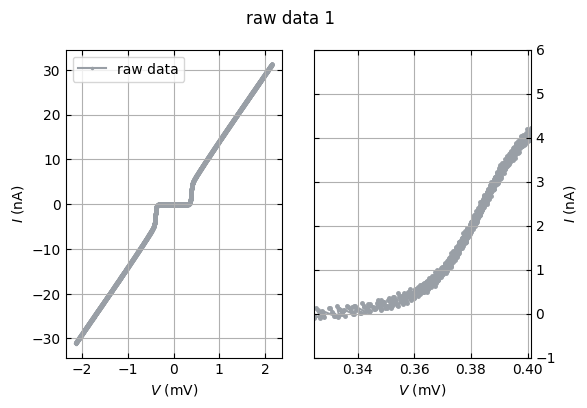

In [152]:
title = 'raw data 1'

%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=0.15)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0])
ax_I2 = fig.add_subplot(gs[1])
for ax in [ax_I, ax_I2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.set_xlabel('$V$ (mV)')

ax_I2.set_xlim((0.85*.382, 1.05*.382))
ax_I2.set_ylim((-1, 6))
# endregion

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)

# region finish plot
ax_I.legend(['raw data'])
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion

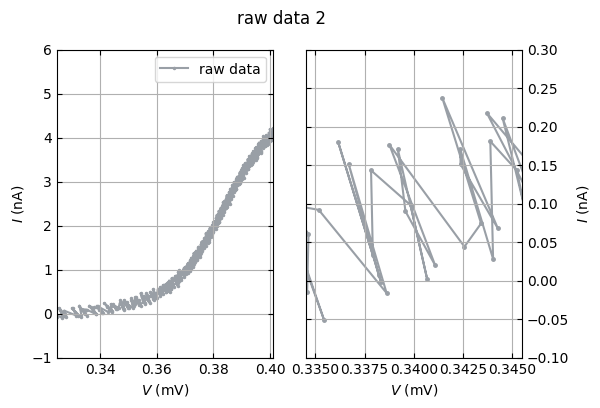

In [153]:
title = 'raw data 2'
%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=0.15)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0])
ax_I2 = fig.add_subplot(gs[1])
for ax in [ax_I, ax_I2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.set_xlabel('$V$ (mV)')

ax_I.set_xlim((0.85*.382, 1.05*.382))
ax_I.set_ylim((-1, 6))

ax_I2.set_xlim((0.3345, .3455))
ax_I2.set_ylim((-.1, .3))
# endregion

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)

# region finish plot
ax_I.legend(['raw data'])
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion

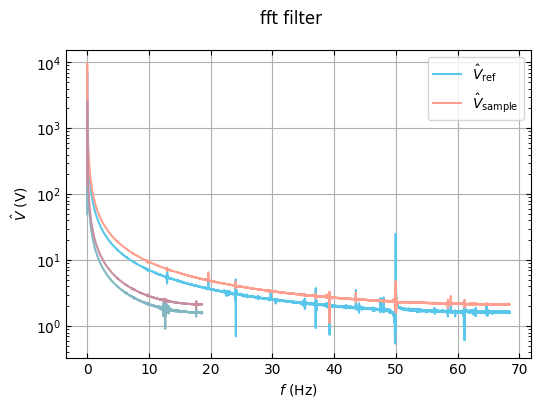

In [154]:
title = 'fft filter'

%matplotlib inline
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 1, height_ratios=[1], wspace=0.1, hspace=.4)  # big gap between col0 and col1

ax_f = fig.add_subplot(gs[0])

for ax in [ax_f]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()

ax_f.set_ylabel('$\hat{V}$ (V)')
ax_f.set_xlabel('$f$ (Hz)')

freq_Hz, signal1_fft_V = compute_fft(time_s, signal1_V)
freq_Hz, signal2_fft_V = compute_fft(time_s, signal2_V)
freq_raw_Hz, signal1_raw_fft_V = compute_fft(time_raw_s, signal1_raw_V)
freq_raw_Hz, signal2_raw_fft_V = compute_fft(time_raw_s, signal2_raw_V)

ax_f.semilogy(freq_raw_Hz, signal2_raw_fft_V, label='$\hat{V}_\mathrm{ref}$', color=colors(0))
ax_f.semilogy(freq_raw_Hz, signal1_raw_fft_V, label='$\hat{V}_\mathrm{sample}$', color=colors(1))
ax_f.semilogy(freq_Hz, signal2_fft_V, color=colors(3, .5))
ax_f.semilogy(freq_Hz, signal1_fft_V, color=colors(7, .5))

ax_f.legend()

fig.suptitle(title)
plt.savefig(f'{title}.png')

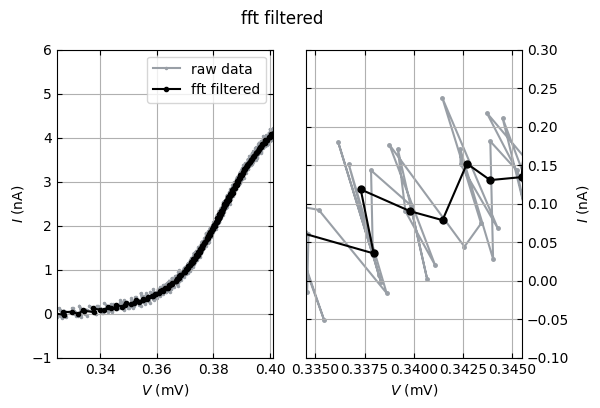

In [155]:
title = 'fft filtered'

%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=0.15)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0])
ax_I2 = fig.add_subplot(gs[1])
for ax in [ax_I, ax_I2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.set_xlabel('$V$ (mV)')

ax_I.set_xlim((0.85*.382, 1.05*.382))
ax_I.set_ylim((-1, 6))

ax_I2.set_xlim((0.3345, .3455))
ax_I2.set_ylim((-.1, .3))
# endregion

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)
    ax.plot(voltage_mV, current_nA, '.-', ms=ms[j]*2, color='k', zorder=3)


# region finish plot
ax_I.legend(['raw data', 'fft filtered'])
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion

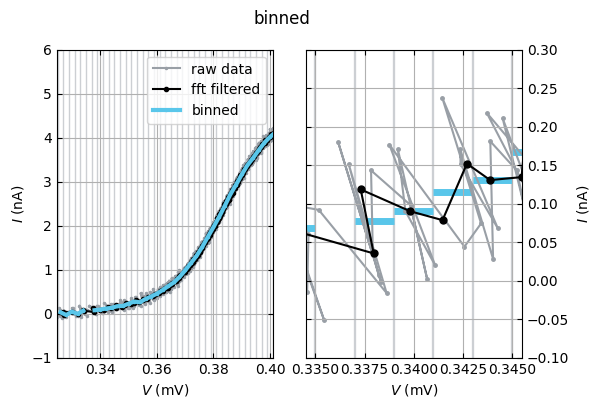

In [156]:
title = 'binned'
%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=0.15)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0])
ax_I2 = fig.add_subplot(gs[1])
for ax in [ax_I, ax_I2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.set_xlabel('$V$ (mV)')

ax_I.set_xlim((0.85*.382, 1.05*.382))
ax_I.set_ylim((-1, 6))

ax_I2.set_xlim((0.3345, .3455))
ax_I2.set_ylim((-.1, .3))
# endregion



voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_mV, current_nA, voltage_bins_mV)
conductance_binned_G0 = np.gradient(voltage_bins_mV, current_binned_nA)

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)
    ax.plot(voltage_mV, current_nA, '.-', ms=ms[j]*2, color='k', zorder=3)

ax_I.plot(voltage_bins_mV, current_binned_nA, '.-', lw = ms[0], ms=ms[0], zorder=5, color=colors(0))
for j, ax in enumerate([ax_I, ax_I2]):
    for i,v in zip(current_binned_nA, voltage_bins_mV):
        ax.axvline(v-dV_mV/2, color=colors(2, .5), lw=ms[j]/3, ls='-', zorder=0)
    
for i,v in zip(current_binned_nA, voltage_bins_mV):
    ax_I2.hlines(i, v-dV_mV/2, v+dV_mV/2, color=colors(0), lw=ms[1], zorder=0)


ax_I.legend(['raw data', 'fft filtered', 'binned'])

# region finish plot
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion

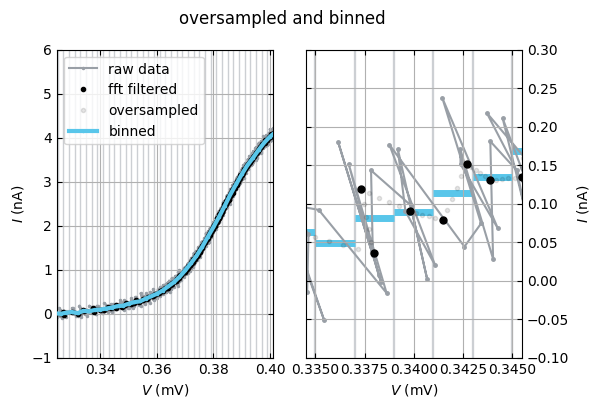

In [157]:
title = 'oversampled and binned'

%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=0.15)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0])
ax_I2 = fig.add_subplot(gs[1])
for ax in [ax_I, ax_I2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.set_xlabel('$V$ (mV)')

ax_I.set_xlim((0.85*.382, 1.05*.382))
ax_I.set_ylim((-1, 6))

ax_I2.set_xlim((0.3345, .3455))
ax_I2.set_ylim((-.1, .3))
# endregion

voltage_oversampled_mV, current_oversampled_nA = oversample(voltage_mV, current_nA, upsample=5)

voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV)
conductance_binned_G0 = np.gradient(voltage_bins_mV, current_binned_nA)

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)
    ax.plot(voltage_mV, current_nA, '.', ms=ms[j]*2, color='k', zorder=3)
    ax.plot(voltage_oversampled_mV, current_oversampled_nA, '.', color=[0,0,0,0.1])

ax_I.plot(voltage_bins_mV, current_binned_nA, '.-', lw = ms[0], ms=ms[0], zorder=5, color=colors(0))
for j, ax in enumerate([ax_I, ax_I2]):
    for i,v in zip(current_binned_nA, voltage_bins_mV):
        ax.axvline(v-dV_mV/2, color=colors(2, .5), lw=ms[j]/3, ls='-', zorder=0)
    
for i,v in zip(current_binned_nA, voltage_bins_mV):
    ax_I2.hlines(i, v-dV_mV/2, v+dV_mV/2, color=colors(0), lw=ms[1], zorder=0)


ax_I.legend(['raw data', 'fft filtered','oversampled' ,'binned'])

# region finish plot
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion

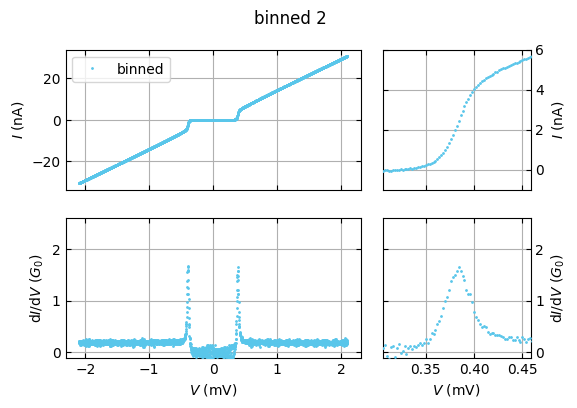

In [158]:
title = 'binned 2'

# region init plot
%matplotlib inline
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[4, 2], wspace=0.1)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0,0])
ax_G = fig.add_subplot(gs[1,0])
ax_I2 = fig.add_subplot(gs[0,1])
ax_G2 = fig.add_subplot(gs[1,1])

for ax in [ax_I, ax_I2, ax_G, ax_G2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I, ax_G]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2, ax_G2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_G, ax_G2]:
    ax.set_ylabel('d$I/$d$V$ ($G_0$)')
    ax.set_xlabel('$V$ (mV)')
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.tick_params(labelbottom=False)

ax_I.sharex(ax_G)
ax_I2.sharex(ax_G2)

ax_I2.set_xlim((0.8*.382, 1.2*.382))
ax_I2.set_ylim((-1, 6))
ax_G.set_ylim((-.1, .4))
ax_G2.set_ylim((-.1, .4))
# endregion

ax_G.set_ylim((-.1, 2.6))
ax_G2.set_ylim((-.1, 2.6))

dV_mV = 2e-3
from scipy.signal import savgol_filter
voltage_oversampled_mV, current_oversampled_nA = oversample(voltage_mV, current_nA, upsample=100)
voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV)
conductance_binned_G0 = np.gradient(current_binned_nA, voltage_bins_mV) / G_0_muS
current_savgol_nA = savgol_filter(current_binned_nA, 13, 2, mode='constant', cval=np.nan)
conductance_savgol_G0 = np.gradient(current_savgol_nA, voltage_bins_mV) / G_0_muS

ms=2
for ax in [ax_I, ax_I2]:
    ax.plot(voltage_bins_mV, current_binned_nA, '.', ms=ms, color=colors(0), zorder=3)

for ax in [ax_G, ax_G2]:
    ax.plot(voltage_bins_mV, conductance_binned_G0, '.', ms=ms, color=colors(0), zorder=3)

ax_I.legend(['binned', 'fft filtered' ,'binned', 'savgol'])

# region finish plot
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion


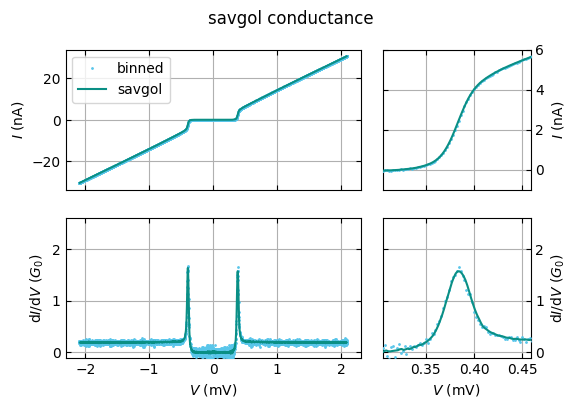

In [159]:
title = 'savgol conductance'

%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[4, 2], wspace=0.1)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0,0])
ax_G = fig.add_subplot(gs[1,0])
ax_I2 = fig.add_subplot(gs[0,1])
ax_G2 = fig.add_subplot(gs[1,1])

for ax in [ax_I, ax_I2, ax_G, ax_G2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I, ax_G]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2, ax_G2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_G, ax_G2]:
    ax.set_ylabel('d$I/$d$V$ ($G_0$)')
    ax.set_xlabel('$V$ (mV)')
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.tick_params(labelbottom=False)

ax_I.sharex(ax_G)
ax_I2.sharex(ax_G2)

ax_I2.set_xlim((0.8*.382, 1.2*.382))
ax_I2.set_ylim((-1, 6))
ax_G.set_ylim((-.1, .4))
ax_G2.set_ylim((-.1, .4))
# endregion

ax_G.set_ylim((-.1, 2.6))
ax_G2.set_ylim((-.1, 2.6))

dV_mV = 2e-3
from scipy.signal import savgol_filter
voltage_oversampled_mV, current_oversampled_nA = oversample(voltage_mV, current_nA, upsample=100)
voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV)
conductance_binned_G0 = np.gradient(current_binned_nA, voltage_bins_mV) / G_0_muS
current_savgol_nA = savgol_filter(current_binned_nA, 13, 2, mode='constant', cval=np.nan)
conductance_savgol_G0 = np.gradient(current_savgol_nA, voltage_bins_mV) / G_0_muS

ms=2
for ax in [ax_I, ax_I2]:
    ax.plot(voltage_bins_mV, current_binned_nA, '.', ms=ms, color=colors(0), zorder=3)
    ax.plot(voltage_bins_mV, current_savgol_nA, '-', color=colors(4), zorder=4)

for ax in [ax_G, ax_G2]:
    ax.plot(voltage_bins_mV, conductance_binned_G0, '.', ms=ms, color=colors(0), zorder=3)
    ax.plot(voltage_bins_mV+dV_mV/2, conductance_savgol_G0, '-', color=colors(4), zorder=4)

ax_I.legend(['binned', 'savgol'])

# region finish plot
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion


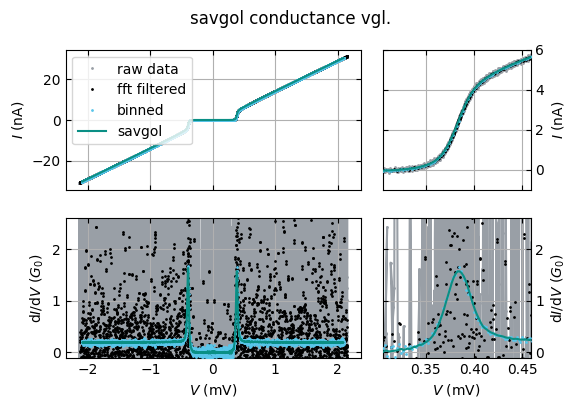

: 

In [ ]:
title = 'savgol conductance vgl.'

%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[4, 2], wspace=0.1)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0,0])
ax_G = fig.add_subplot(gs[1,0])
ax_I2 = fig.add_subplot(gs[0,1])
ax_G2 = fig.add_subplot(gs[1,1])

for ax in [ax_I, ax_I2, ax_G, ax_G2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_I, ax_G]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2, ax_G2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_G, ax_G2]:
    ax.set_ylabel('d$I/$d$V$ ($G_0$)')
    ax.set_xlabel('$V$ (mV)')
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.tick_params(labelbottom=False)

ax_I.sharex(ax_G)
ax_I2.sharex(ax_G2)

ax_I2.set_xlim((0.8*.382, 1.2*.382))
ax_I2.set_ylim((-1, 6))
ax_G.set_ylim((-.1, .4))
ax_G2.set_ylim((-.1, .4))
# endregion



ax_G.set_ylim((-.1, 2.6))
ax_G2.set_ylim((-.1, 2.6))

dV_mV = 2e-3
from scipy.signal import savgol_filter
voltage_oversampled_mV, current_oversampled_nA = oversample(voltage_mV, current_nA, upsample=100)
voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV)
conductance_binned_G0 = np.gradient(current_binned_nA, voltage_bins_mV) / G_0_muS
current_savgol_nA = savgol_filter(current_binned_nA, 13, 2, mode='constant', cval=np.nan)
conductance_savgol_G0 = np.gradient(current_savgol_nA, voltage_bins_mV) / G_0_muS

ms=2
for ax in [ax_I, ax_I2]:
    ax.plot(voltage_raw_mV, current_raw_nA, '.', ms=ms, color=colors(2), zorder=1)
    ax.plot(voltage_mV, current_nA, '.', ms=ms, color='k', zorder=2)
    ax.plot(voltage_bins_mV, current_binned_nA, '.', ms=ms, color=colors(0), zorder=3)
    ax.plot(voltage_bins_mV, current_savgol_nA, '-', color=colors(4), zorder=4)

for ax in [ax_G, ax_G2]:
    ax.plot(voltage_raw_mV, conductance_raw_G0, '.-', ms=ms, color=colors(2), zorder=1)
    ax.plot(voltage_mV, conductance_G0, '.', ms=ms, color='k', zorder=2)
    ax.plot(voltage_bins_mV, conductance_binned_G0, '.', ms=ms, color=colors(0), zorder=3)
    ax.plot(voltage_bins_mV+dV_mV/2, conductance_savgol_G0, '-', color=colors(4), zorder=4)

ax_I.legend(['raw data', 'fft filtered' ,'binned', 'savgol'])

# region finish plot
fig.suptitle(title)
plt.savefig(f'{title}.png')
# endregion


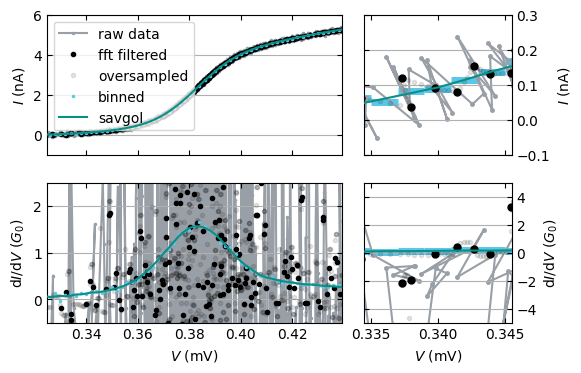

In [127]:
%matplotlib inline
# region init plot
plt.close(1)
fig = plt.figure(1, figsize=(6, 4))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[4, 2], wspace=0.1)  # big gap between col0 and col1

ax_I = fig.add_subplot(gs[0,0])
ax_G = fig.add_subplot(gs[1,0])
ax_I2 = fig.add_subplot(gs[0,1])
ax_G2 = fig.add_subplot(gs[1,1])

for ax in [ax_I, ax_I2, ax_G, ax_G2]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid(axis='y')
for ax in [ax_I, ax_G]:
    ax.tick_params(labelleft=True, labelright=False)
    ax.yaxis.set_label_position("left")
for ax in [ax_I2, ax_G2]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_G, ax_G2]:
    ax.set_ylabel('d$I/$d$V$ ($G_0$)')
    ax.set_xlabel('$V$ (mV)')
for ax in [ax_I, ax_I2]:
    ax.set_ylabel('$I$ (nA)')
    ax.tick_params(labelbottom=False)

ax_I.sharex(ax_G)
ax_I2.sharex(ax_G2)

ax_I2.set_xlim((0.8*.382, 1.2*.382))
ax_I2.set_ylim((-1, 6))
ax_G.set_ylim((-.1, .4))
ax_G2.set_ylim((-.1, .4))
# endregion

ax_I.set_xlim((0.85*.382, 1.15*.382))
ax_I.set_ylim((-1, 6))
ax_I2.set_xlim((0.3345, .3455))
ax_I2.set_ylim((-.1, .3))
ax_G.set_ylim((-.5, 2.5))
ax_G2.set_ylim((-5, 5))

title = 'test'

voltage_oversampled_mV, current_oversampled_nA = oversample(voltage_mV, current_nA, upsample=5)
voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV)

conductance_G0 = np.gradient(current_nA, voltage_mV) / G_0_muS
conductance_raw_G0 = np.gradient(current_raw_nA, voltage_raw_mV) / G_0_muS
conductance_oversampled_G0 = np.gradient(current_oversampled_nA, voltage_oversampled_mV) / G_0_muS
conductance_binned_G0 = np.gradient(current_binned_nA, voltage_bins_mV) / G_0_muS

ms = [3, 5.0]
for j, ax in enumerate([ax_I, ax_I2]):
    ax.plot(voltage_raw_mV, current_raw_nA, '.-', ms=ms[j], color=colors(2), zorder=1)
    ax.plot(voltage_mV, current_nA, '.', ms=ms[j]*2, color='k', zorder=3)
    ax.plot(voltage_oversampled_mV, current_oversampled_nA, '.', color=[0,0,0,0.1])


for j, ax in enumerate([ax_G, ax_G2]):
    ax.plot(voltage_raw_mV, conductance_raw_G0, '.-', ms=ms[j], color=colors(2), zorder=1)
    ax.plot(voltage_mV, conductance_G0, '.', ms=ms[j]*2, color='k', zorder=3)
    ax.plot(voltage_oversampled_mV, conductance_oversampled_G0 , '.', color=[0,0,0,0.1])
    
ax_I.plot(voltage_bins_mV, current_binned_nA, '.', lw = ms[0], ms=ms[0], zorder=5, color=colors(0))
ax_G.plot(voltage_bins_mV, conductance_binned_G0, '.', lw = ms[0], ms=ms[0], zorder=5, color=colors(0))

for j, ax in enumerate([ax_I, ax_I2]):
    # for i,v in zip(current_binned_nA, voltage_bins_mV):
    #     ax.axvline(v-dV_mV/2, color=colors(2, .5), lw=ms[j]/3, ls='-', zorder=0)
    ax.plot(voltage_bins_mV, current_savgol_nA, '-', color=colors(4), zorder=7)
    
for j, ax in enumerate([ax_G, ax_G2]):
    # for i,v in zip(current_binned_nA, voltage_bins_mV):
    #     ax.axvline(v-dV_mV/2, color=colors(2, .5), lw=ms[j]/3, ls='-', zorder=0)
    ax.plot(voltage_bins_mV, conductance_savgol_G0, '-', color=colors(4), zorder=7)
    
for i,v in zip(current_binned_nA, voltage_bins_mV):
    ax_I2.hlines(i, v-dV_mV/2, v+dV_mV/2, color=colors(0), lw=ms[1], zorder=0)

for g,v in zip(conductance_binned_G0, voltage_bins_mV):
    ax_G2.hlines(g, v-dV_mV/2, v+dV_mV/2, color=colors(0), lw=ms[1], zorder=0)


ax_I.legend(['raw data', 'fft filtered','oversampled' ,'binned', 'savgol'])

In [ ]:
plt.close("all")

In [ ]:
voltage_smoothed_mV = np.array(
    sm.nonparametric.lowess(voltage_mV, time_s, frac=frac)[:, 1], dtype="float64"
)
current_smoothed_nA = np.array(
    sm.nonparametric.lowess(current_nA, time_s, frac=frac)[:, 1], dtype="float64"
)
conductance_smoothed_G0 = np.array(
    sm.nonparametric.lowess(conductance_G0, voltage_mV, frac=frac)[:, 1],
    dtype="float64",
)

voltage_oversampled_mV, current_oversampled_nA = oversample(
    voltage_smoothed_mV, current_smoothed_nA, factor=upsample
)
conductance_oversampled_G0 = oversample(
    voltage_smoothed_mV, conductance_smoothed_G0, factor=upsample
)[1]

voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")
current_binned_nA = bin_y_over_x(
    voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV
)
conductance_binned_G0 = bin_y_over_x(
    voltage_oversampled_mV, conductance_oversampled_G0, voltage_bins_mV
)

conductance_G0 = np.gradient(current_nA, voltage_mV) / G_0_muS
conductance_smoothed_G0 = (
    np.gradient(current_smoothed_nA, voltage_smoothed_mV) / G_0_muS
)
conductance_oversampled_G0 = (
    np.gradient(current_oversampled_nA, voltage_oversampled_mV) / G_0_muS
)
conductance_binned_G0 = np.gradient(current_binned_nA, voltage_bins_mV) / G_0_muS


plt.close(1)
fig, [ax_I, ax_G] = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ax_I.plot(voltage_mV, current_nA, ".", color="k")
ax_I.plot(voltage_smoothed_mV, current_smoothed_nA, ".-", color="grey", lw=2)
ax_I.plot(voltage_oversampled_mV, current_oversampled_nA, ".", color="lightgrey", ms=1)
ax_I.plot(voltage_bins_mV, current_binned_nA, "r.-")

ax_G.plot(voltage_mV, conductance_G0, ".", color="k")
ax_G.plot(voltage_smoothed_mV, conductance_smoothed_G0, ".-", color="grey", lw=2)
ax_G.plot(
    voltage_oversampled_mV, conductance_oversampled_G0, ".", color="lightgrey", ms=1
)
ax_G.plot(voltage_bins_mV, conductance_binned_G0, "r.-")
ax_G.set_ylim(-0.1, 5.1)

voltage_bins_mV = np.append(voltage_bins_mV, voltage_bins_mV[-1] + dv_mV)
voltage_bins_mV -= dv_mV / 2

for v_bin in voltage_bins_mV:
    ax_I.axvline(v_bin, color="gray", lw=0.5, ls="-")
    ax_G.axvline(v_bin, color="gray", lw=0.5, ls="-")

TypeError: oversample() got an unexpected keyword argument 'factor'

In [10]:
index_to_show: int = 0
off_sweep: int = 1
upsample: int = 100
frac = 1 / 400
frac2 = 1 / 100
dV_mV = 1 * 1e-3


mask1 = all_index == index_to_show
mask2 = all_trigger == off_sweep
mask2 = shrink_blocks(mask2, x=20, y=0)
mask = np.logical_and(mask1, mask2)

voltage_mV = all_voltage_mV[mask]
current_nA = all_current_nA[mask]
time_s = all_time_continued[mask]

voltage_oversampled_mV, current_oversampled_nA = oversample(
    voltage_mV, current_nA, upsample=upsample
)

voltage_bins_mV = np.arange(-2.1, 2.1 + dV_mV, dV_mV, dtype="float64")

current_binned_nA = bin_y_over_x(
    voltage_oversampled_mV, current_oversampled_nA, voltage_bins_mV
)

current_smoothed_nA = np.array(
    sm.nonparametric.lowess(current_binned_nA, voltage_bins_mV, frac=frac)[:, 1],
    dtype="float64",
)

conductance_smoothed_G0 = np.gradient(current_smoothed_nA, voltage_bins_mV) / G_0_muS

conductance_smoothed2_G0 = np.array(
    sm.nonparametric.lowess(conductance_smoothed_G0, voltage_bins_mV, frac=frac2)[:, 1],
    dtype="float64",
)

conductance_G0 = np.gradient(current_nA, voltage_mV) / G_0_muS


plt.close(1)
fig, [ax_I, ax_G] = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ax_I.plot(voltage_mV, current_nA, ".", color="k")
ax_I.plot(voltage_oversampled_mV, current_oversampled_nA, ".", color="lightgrey", ms=1)
ax_I.plot(voltage_bins_mV, current_binned_nA, ".", color="red")
ax_I.plot(voltage_bins_mV, current_smoothed_nA, "-", color="red", lw=2)

ax_G.plot(voltage_mV, conductance_G0, ".", color="k")
ax_G.plot(voltage_bins_mV, conductance_smoothed_G0, ".", color="r", lw=2)
ax_G.plot(voltage_bins_mV, conductance_smoothed2_G0, "-", color="r", lw=2)
ax_G.set_ylim(-0.1, 5.1)

voltage_bins_mV = np.append(voltage_bins_mV, voltage_bins_mV[-1] + dv_mV)
voltage_bins_mV -= dv_mV / 2

# for v_bin in voltage_bins_mV:
#     ax_I.axvline(v_bin, color='lightgrey', lw=0.5, ls='-')
#     ax_G.axvline(v_bin, color='lightgrey', lw=0.5, ls='-')

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_11081/1527459915.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(big[0, 0, :])
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_11081/1527459915.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(big[0, 1, :])


NameError: name 'dv_mV' is not defined

In [357]:
# get limits
%matplotlib inline
plt.figure(1)
plt.plot(all_voltage_mV[all_offset], all_current_nA[all_offset])
V_off_lim = plt.gca().get_xlim()
I_off_lim = plt.gca().get_ylim()
plt.close(1)

plt.figure(2)
plt.plot(all_voltage_mV[all_sweep], all_current_nA[all_sweep])
V_IV_lim = plt.gca().get_xlim()
I_IV_lim = plt.gca().get_ylim()
plt.close(2)

plt.figure(3)
plt.plot(all_time, all_voltage_mV)
t_lim = plt.gca().get_xlim()
plt.close(3)

Text(0.5, 533.5555555555555, 'no irradiation')

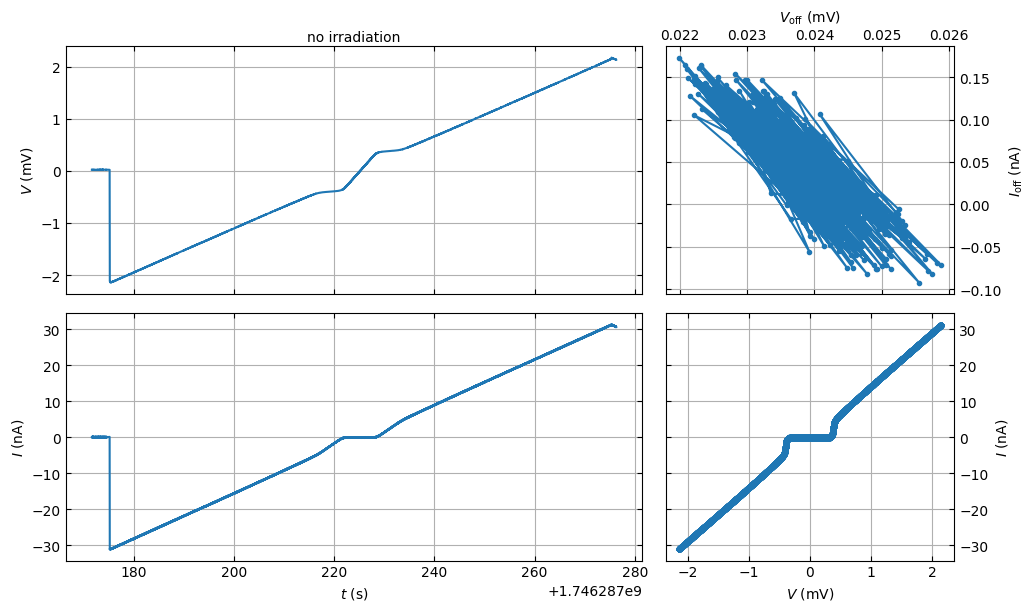

In [415]:
# steady Oszilloscope for no irradiation (2*2)
%matplotlib inline

# --- create figure ---
fig = plt.figure(0, figsize=(10, 6))
axs = fig.subplots(
    2, 2,
    gridspec_kw={
        "width_ratios": [2, 1],
        "height_ratios": [1, 1]
    }
)

# --- axs ---
ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax_xy = axs[1, 1]
ax_off = axs[0, 1]

# --- plot data ---
ax1.plot(all_time[all_index==0], all_voltage_mV[all_index==0])
ax2.plot(all_time[all_index==0], all_current_nA[all_index==0])

ax_off.plot(all_voltage_mV[all_index==0][all_offset[all_index==0]], all_current_nA[all_index==0][all_offset[all_index==0]], ".-")
ax_xy.plot(all_voltage_mV[all_index==0][all_upsweep[all_index==0]], all_current_nA[all_index==0][all_upsweep[all_index==0]], ".-")

# --- style ---
ax1.sharex(ax2)
for ax in [ax1, ax2, ax_off, ax_xy]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_off, ax_xy]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_off]:
    ax.xaxis.set_label_position("top")
    ax.tick_params(labelbottom=False, labeltop=True)
for ax in [ax1]:
    ax.xaxis.set_label_position("top")
    ax1.tick_params(labelbottom=False)
fig.tight_layout()

# --- labels ---
ax_off.set_xlabel("$V_{\mathrm{off}}$ (mV)")
ax_off.set_ylabel("$I_{\mathrm{off}}$ (nA)")
ax1.set_ylabel("$V$ (mV)")
ax2.set_ylabel("$I$ (nA)")
ax2.set_xlabel("$t$ (s)")
ax_xy.set_xlabel("$V$ (mV)")
ax_xy.set_ylabel("$I$ (nA)")
ax1.set_xlabel(f"no irradiation")

# # --- limits ---
# ax1.set_xlim(t_lim)
# ax1.set_ylim(V_IV_lim)
# ax2.set_xlim(t_lim)
# ax2.set_ylim(I_IV_lim)
# ax_xy.set_xlim(V_IV_lim)
# ax_xy.set_ylim(I_IV_lim)
# ax_off.set_xlim(V_off_lim)
# ax_off.set_ylim(I_off_lim)

Text(0.5, 1.0, 'test 18.3 GHz')

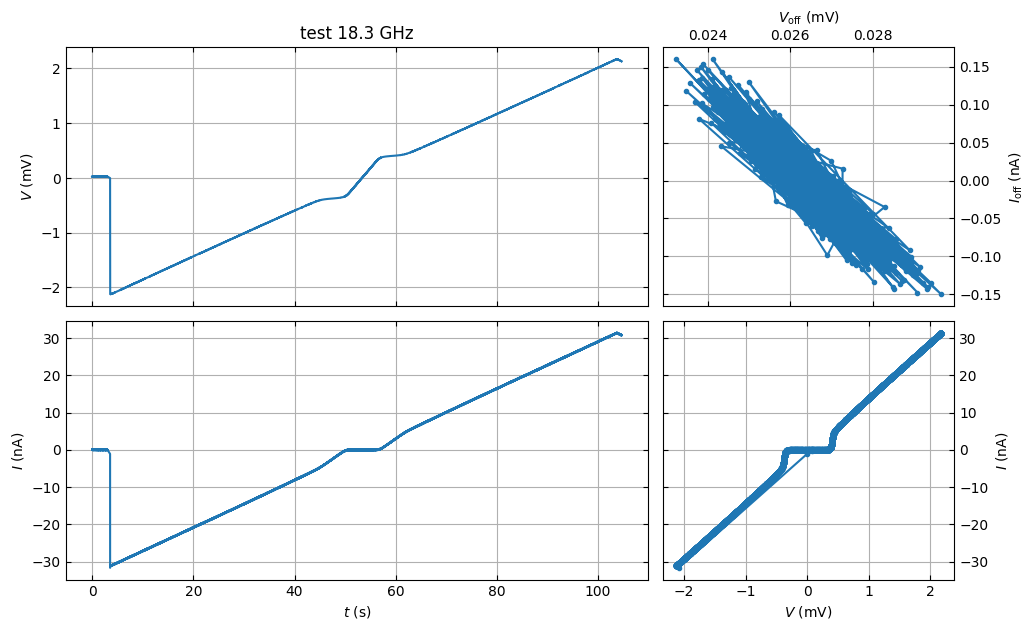

: 

In [ ]:
# steady Oszilloscope
%matplotlib inline

# --- create figure ---
fig = plt.figure(0, figsize=(10, 6))
axs = fig.subplots(
    2, 2,
    gridspec_kw={
        "width_ratios": [2, 1],
        "height_ratios": [1, 1]
    }
)

# --- axs ---
ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax1.sharex(ax2)
ax_off = axs[0, 1]
ax_xy = axs[1, 1]

# --- plot data ---
ax1.plot(all_time[all_index==0], all_voltage_mV[all_index==0])
ax2.plot(all_time[all_index==0], all_current_nA[all_index==0])

ax_off.plot(all_voltage_mV[all_index==0][all_offset[all_index==0]], all_current_nA[all_index==0][all_offset[all_index==0]], ".-")
ax_xy.plot(all_voltage_mV[all_index==0][all_sweep[all_index==0]], all_current_nA[all_index==0][all_sweep[all_index==0]], ".-")

# --- style ---
for ax in [ax1, ax2, ax_off, ax_xy]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
    ax.grid()
for ax in [ax_off, ax_xy]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")
for ax in [ax_off]:
    ax.xaxis.set_label_position("top")
    ax.tick_params(labelbottom=False, labeltop=True)
for ax in [ax1]:
    ax1.tick_params(labelbottom=False)
fig.tight_layout()

# --- labels ---
ax_off.set_xlabel("$V_{\mathrm{off}}$ (mV)")
ax_off.set_ylabel("$I_{\mathrm{off}}$ (nA)")
ax1.set_ylabel("$V$ (mV)")
ax2.set_ylabel("$I$ (nA)")
ax2.set_xlabel("$t$ (s)")
ax_xy.set_xlabel("$V$ (mV)")
ax_xy.set_ylabel("$I$ (nA)")
ax1.set_title(f"test {nu_GHz:.1f} GHz")

# # --- limits ---
# ax1.set_xlim(t_lim)
# ax1.set_ylim(V_IV_lim)
# ax2.set_xlim(t_lim)
# ax2.set_ylim(I_IV_lim)
# ax_xy.set_xlim(V_IV_lim)
# ax_xy.set_ylim(I_IV_lim)
# ax_off.set_xlim(V_off_lim)
# ax_off.set_ylim(I_off_lim)

In [342]:
%matplotlib qt

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- create figure and axes ---
plt.close(10)
fig = plt.figure(10, figsize=(10, 6))

axs = fig.subplots(
    2, 2,
    gridspec_kw={
        "width_ratios": [2, 1],
        "height_ratios": [1, 1]
    }
)

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax1.sharex(ax2)
ax_off = axs[0, 1]
ax_xy = axs[1, 1]

# --- initialize lines (empty at start) ---
line_v, = ax1.plot([], [], color="C0")      # voltage vs time
line_i, = ax2.plot([], [], color="C1")      # current vs time
line_off, = ax_off.plot([], [], ".-", color="C2")  # offset curve
line_xy, = ax_xy.plot([], [], ".-", color="C3")    # IV curve

# --- configure axes ---
ax_off.set_xlabel("$V_{\\mathrm{off}}$ (mV)")
ax_off.set_ylabel("$I_{\\mathrm{off}}$ (nA)")

ax1.set_ylabel("$V$ (mV)")
ax2.set_ylabel("$I$ (nA)")
ax2.set_xlabel("$t$ (s)")

ax_xy.set_xlabel("$V$ (mV)")
ax_xy.set_ylabel("$I$ (nA)")

for ax in [ax1, ax2, ax_off, ax_xy]:
    ax.tick_params(direction="in", top=True, bottom=True, left=True, right=True, which="both")
    ax.grid()

for ax in [ax_off, ax_xy]:
    ax.tick_params(labelleft=False, labelright=True)
    ax.yaxis.set_label_position("right")

ax_off.xaxis.set_label_position("top")
ax_off.tick_params(labelbottom=False, labeltop=True)

ax1.tick_params(labelbottom=False)

ax1.set_title(f"test {nu_GHz:.1f} GHz")
fig.tight_layout()

# --- limits ---
ax1.set_xlim(t_lim)
ax1.set_ylim(V_IV_lim)
ax2.set_xlim(t_lim)
ax2.set_ylim(I_IV_lim)
ax_xy.set_xlim(V_IV_lim)
ax_xy.set_ylim(I_IV_lim)
ax_off.set_xlim(V_off_lim)
ax_off.set_ylim(I_off_lim)

# --- update function for animation ---
def update(frame):
    # incrementally extend each line
    line_v.set_data(all_time[:frame], all_voltage_mV[:frame])
    line_i.set_data(all_time[:frame], all_current_nA[:frame])
    line_off.set_data(all_voltage_mV[all_offset][:frame], all_current_nA[all_offset][:frame])
    line_xy.set_data(all_voltage_mV[all_sweep][:frame], all_current_nA[all_sweep][:frame])
    return line_v, line_i, line_off, line_xy

# --- create animation ---
ani = FuncAnimation(
    fig, update, frames=range(0, len(all_time), 10),
    interval=.01, blit=True, repeat=False
)

plt.show()

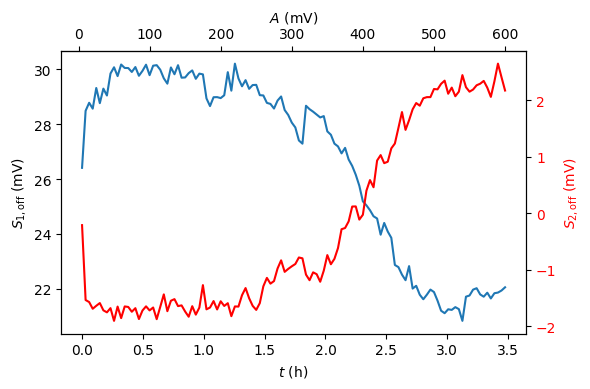

In [143]:
# Offset voltages over time
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax1.plot(time_off_h, voltage_offset_1_V * 1000)
ax2.plot(time_off_h, voltage_offset_2_V * 1000, "r")
ax1.set_ylabel("$S_{1, \mathrm{off}}$ (mV)")
ax2.set_ylabel("$S_{2, \mathrm{off}}$ (mV)", color="r")
ax1.set_xlabel("$t$ (h)")
ax2.tick_params(axis="y", labelcolor="r")

a, b = np.polyfit(time_off_h, A_mV, 1)


def A(t):
    return t * a + b


def t(A):
    return (A - b) / a


ax3 = ax1.secondary_xaxis("top", functions=(A, t))
ax3.set_xlabel("$A$ (mV)")

plt.tight_layout()
plt.show()

Text(0, 0.5, '$I_\\mathrm{off}$ (pA)')

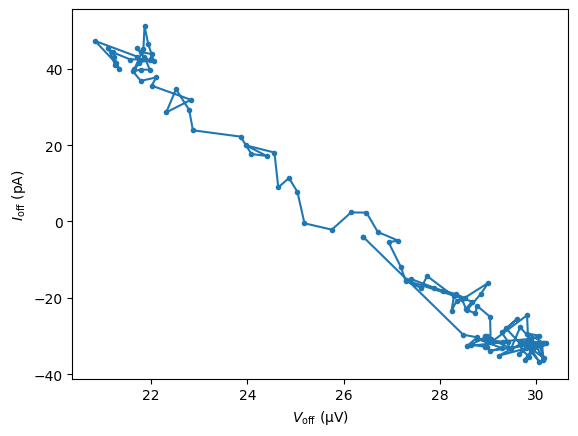

In [142]:
# Verstärker schwanken um 100pA / 10muV

plt.plot(voltage_off_mV * 1000, current_off_nA * 1000, ".-")
plt.xlabel("$V_\mathrm{off}$ (µV)")
plt.ylabel("$I_\mathrm{off}$ (pA)")

In [30]:
for key in data.keys():
    print(key)
for key in dir(eva):
    print(key)

iv_tuples_raw
iv_tuples
downsample_frequency
temperature
time_start
time_stop
current
voltage
time_current
time_voltage
temperature_current
temperature_voltage
differential_conductance
differential_resistance
plain
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__firstlineno__
__format__
__ge__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__static_attributes__
__str__
__subclasshook__
__weakref__
_base_eva_name
_base_name
_iv_eva_name
addKey
amp_1
amp_2
amp_t
amplitude_axis
amplitude_bins
amplitude_maximum
amplitude_minimum
base
base_evaluation
check_for_temperatures
current_axis
current_bins
current_maximum
current_minimum
data_folder
down_sweep
downsample_frequency
eva_current
eva_even_spaced
eva_temperature
eva_voltage
evaluated
figure_folder
file_directory
file_folder
file_name
getAmplifications
getBackupTemperature
getMaps
getMapsAmplitude
getMapsEven

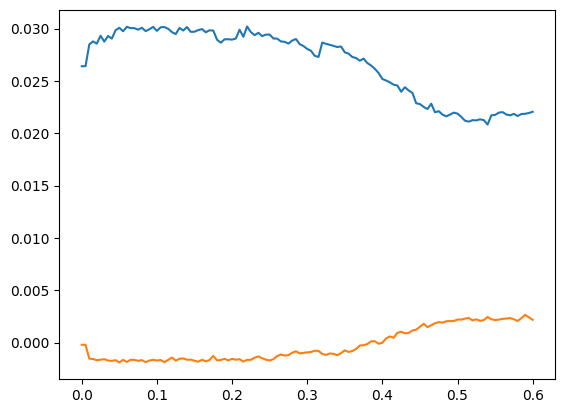

In [35]:
plt.plot(eva.y_axis, eva.voltage_offset_1[: len(eva.y_axis)])
plt.plot(eva.y_axis, eva.voltage_offset_2[: len(eva.y_axis)])